### Import packages

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)


import numpy as np
import math
import pickle
import folium
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier


from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from catboost import Pool, CatBoostRegressor
from sklearn.decomposition import PCA

# Modeling

### Load Data

In [5]:
df_train = pd.read_csv('../data/train_labels_final.csv')
df_train = df_train.drop('Unnamed: 0',axis=1)
df_train

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,latitude,longitude,region
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,6.6,10.60,8.4,2.88,4.10,7.24,4.00,-121.9,41.2,other
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,4.10,7.24,4.00,-120.6,39.7,sierras
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,7.24,4.10,4.00,-119.6,38.3,sierras
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,1.6,NaN,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,7.20,-107.2,44.6,other
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,NaN,1.6,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,10.60,-106.6,40.4,central rockies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50453,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-105.1,38.9,central rockies
50454,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-106.1,39.3,central rockies
50455,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,1.3,2.7,6.7,4.0,2.1,1.5,2.8,6.1,7.1,1.3,4.1,3.9,5.5,9.9,5.30,6.9,3.70,9.93,3.90,1.50,-107.9,37.8,central rockies
50456,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,1.3,2.7,4.0,6.7,2.1,1.5,2.8,7.1,6.1,1.3,3.9,5.5,9.9,4.1,9.93,5.3,10.92,6.90,3.70,6.00,-122.0,43.9,other


In [6]:
#Make sure our data types is correct
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50458 entries, 0 to 50457
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cell_id      50458 non-null  object 
 1   dates        50458 non-null  object 
 2   value        50458 non-null  float64
 3   neighbor_1   50458 non-null  float64
 4   neighbor_2   50458 non-null  float64
 5   neighbor_3   50458 non-null  float64
 6   neighbor_4   50458 non-null  float64
 7   neighbor_5   50458 non-null  float64
 8   neighbor_6   50458 non-null  float64
 9   neighbor_7   50458 non-null  float64
 10  neighbor_8   42424 non-null  float64
 11  neighbor_9   43759 non-null  float64
 12  neighbor_10  47152 non-null  float64
 13  neighbor_11  49849 non-null  float64
 14  neighbor_12  50458 non-null  float64
 15  neighbor_13  50458 non-null  float64
 16  neighbor_14  50458 non-null  float64
 17  neighbor_15  50458 non-null  float64
 18  neighbor_16  50458 non-null  float64
 19  neig

In [7]:
df_train.isna().sum()/len(df_train)

cell_id        0.000000
dates          0.000000
value          0.000000
neighbor_1     0.000000
neighbor_2     0.000000
neighbor_3     0.000000
neighbor_4     0.000000
neighbor_5     0.000000
neighbor_6     0.000000
neighbor_7     0.000000
neighbor_8     0.159222
neighbor_9     0.132764
neighbor_10    0.065520
neighbor_11    0.012069
neighbor_12    0.000000
neighbor_13    0.000000
neighbor_14    0.000000
neighbor_15    0.000000
neighbor_16    0.000000
neighbor_17    0.000000
neighbor_18    0.000000
neighbor_19    0.000000
neighbor_20    0.000000
latitude       0.000000
longitude      0.000000
region         0.000000
dtype: float64

## Train-test-split

Let's do our train-test-split before we begin to build our pipelines.

In [8]:
X_train = df_train.drop(['cell_id','dates','value'],axis=1)
y_train = df_train['value']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Modeling EDA

<AxesSubplot:>

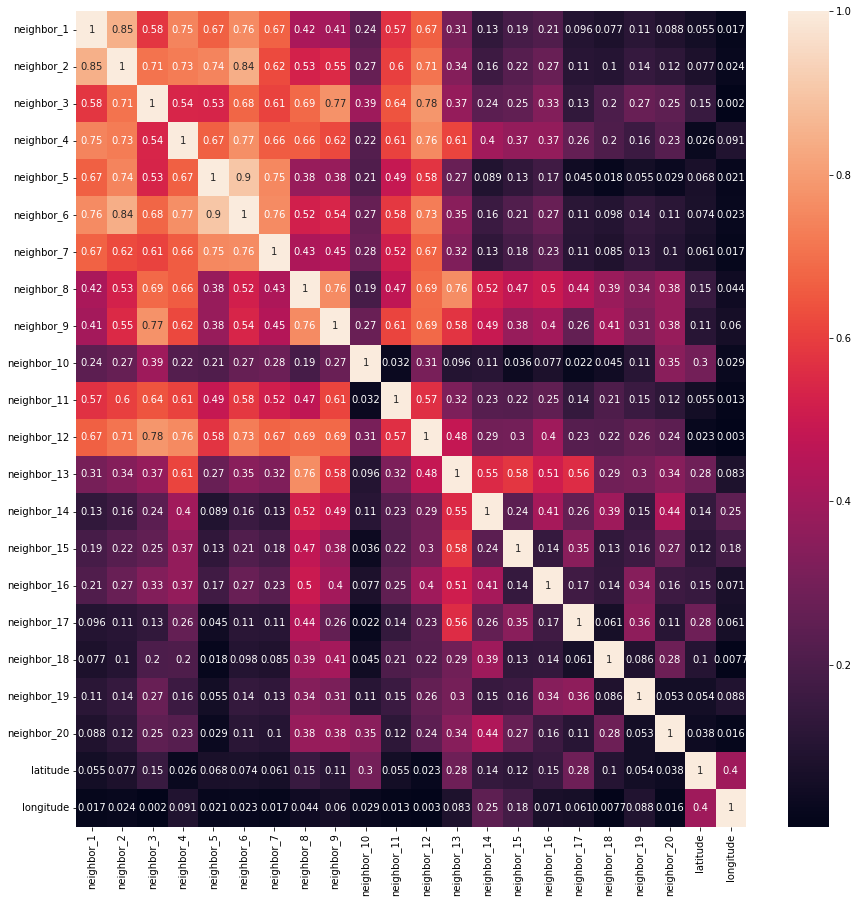

In [9]:
fig, ax = plt.subplots(figsize = (15,15))

sns.heatmap(abs(X_train.corr()),annot=True, ax=ax)

It seems like our top 13 nearest neighbors of ground measured stations are highly correlated. This is possibly because top 13 nearest stations to the grid cell is also near to each other in distance and therefore, the SWE values of the top 13 nearest neighbors are correlated to each other by distance. To reduce the multicollinearity between these stations, we can perform PCA on the first 13 neighbors as part of our pipeline.

## Modeling Building

We are going to begin our model testing with our training data. We will be using pipelines functions, and Function transformers to smooth our model building process and ensure no data leakage takes place in our workflow.

### Functions

In [10]:
def grab_numeric(df):
    
    """
    Helper function to grab only numeric columns from our dataframe.
    """
    return df.select_dtypes(include=['float', 'int'])

In [11]:
def grab_object(df):
    
    """
    Helper function to grab only categorical columns from our dataframe.
    """
    
    return df.select_dtypes(include=['object'])

In [12]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} R_squared
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

Some of these models take a very long time to run. The function below will pickle the models we have to [pickled_models](link).

In [13]:
def pickle_model (model,model_file_name):
    
    """
    This helper function takes in your model and save it under modelname, in a folder parallel to the parent director called
    pickled_models.
    
    model: the model to save.
    model_file_name: (str) file name to save the model as. 
    """
    print (f'Saving model as {model_file_name}...')
    pickle.dump(model,open(f'./pickled_models/{model_file_name}.sav','wb'))
    print(f'{model_file_name} succesfully saved.')
           
    
    

In [14]:
def load_pickle(fullfilepath):
    
    file = open(fullfilepath,'rb')
    object_file = pickle.load(file)
    file.close()
    
    return object_file

#### Testing functions

In [15]:
#Sniff test, ensuring function outputs what we want

num_df=grab_numeric(df_train)
num_df

,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,latitude,longitude
0,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,6.6,10.60,8.4,2.88,4.10,7.24,4.00,-121.9,41.2
1,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,4.10,7.24,4.00,-120.6,39.7
2,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,7.24,4.10,4.00,-119.6,38.3
3,2.3,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,1.6,NaN,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,7.20,-107.2,44.6
4,8.0,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,NaN,1.6,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,10.60,-106.6,40.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50453,1.3,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-105.1,38.9
50454,5.6,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-106.1,39.3
50455,8.8,1.3,2.7,6.7,4.0,2.1,1.5,2.8,6.1,7.1,1.3,4.1,3.9,5.5,9.9,5.30,6.9,3.70,9.93,3.90,1.50,-107.9,37.8
50456,2.9,1.3,2.7,4.0,6.7,2.1,1.5,2.8,7.1,6.1,1.3,3.9,5.5,9.9,4.1,9.93,5.3,10.92,6.90,3.70,6.00,-122.0,43.9


In [16]:
#Sniff test, ensuring function outputs what we want

cat_df = grab_object(df_train)
cat_df.head()

,cell_id,dates,region
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,other
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,sierras
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,sierras
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,other
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,central rockies


#### Building function transformers

In [17]:
GrabNumeric = FunctionTransformer(grab_numeric)
GrabObject = FunctionTransformer(grab_object)

### Building `subpipelines` and `Column Transformer`

We'll create Column Transformers that will scale our features, one hot encode our categorical features and pca the first 13 columns which are our top 13 nearest ground stations.

In [18]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical, then PCA

subpipe_num= Pipeline(steps=[('get_num', GrabNumeric),
                              ('ss', StandardScaler()),
                              ('num_impute', IterativeImputer(estimator=RandomForestRegressor(
                                                                                            n_estimators=4,
                                                                                            max_depth=10,
                                                                                            bootstrap=True,
                                                                                            max_samples=0.5,
                                                                                            n_jobs=2,
                                                                                            random_state=0),
                                                              skip_complete=True,
                                                              random_state=250))
                             ])

subpipe_cat = Pipeline(steps=[('get_obj', GrabObject),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                              ])

subpipe_pca = Pipeline(steps= [('PCA', PCA(n_components=3)),
                              ('ss_pca', StandardScaler()),
                              ])

In [19]:
ct_all = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, X_train.columns),
    ('subpipe_cat', subpipe_cat, X_train.columns)
])

ct_pca = ColumnTransformer(transformers=[
                                        ('subpipe_pca', subpipe_pca, list(range(0,13)))
                                        ], remainder='passthrough')

In [21]:
ct_test_df = pd.DataFrame(ct_all.fit_transform(X_train.head(20)))
ct_test_final_df = pd.DataFrame(ct_pca.fit_transform(ct_test_df))
ct_test_final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.921960,-0.251102,0.079468,0.064701,1.916289,1.309390,-0.705142,-0.376977,0.809579,-0.274829,-1.572454,-0.156705,0.0,1.0,0.0
1,1.921960,-0.251102,0.079468,2.940316,0.367773,1.309390,-0.705142,-0.376977,0.809579,-0.274829,-1.308857,-0.584084,0.0,0.0,1.0
2,1.921960,-0.251102,0.079468,2.940316,0.367773,1.309390,-0.705142,0.599680,-0.250946,-0.274829,-1.106091,-0.982970,0.0,0.0,1.0
3,-0.422931,0.295684,0.032387,-0.438531,-0.600050,-0.570321,-0.477677,-0.843533,-0.858890,0.770894,1.408213,0.812019,0.0,1.0,0.0
4,-0.194933,1.849411,0.401084,-0.438531,-0.600050,-0.570321,-0.477677,-0.843533,-0.858890,1.881976,1.529873,-0.384640,1.0,0.0,0.0
5,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,-0.843533,1.944408,-0.830370,0.455211,0.925986,0.0,1.0,0.0
6,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,1.644765,-0.757566,-0.830370,1.347383,-1.210905,1.0,0.0,0.0
7,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,1.644765,-0.757566,-0.830370,1.306830,-1.096937,1.0,0.0,0.0
8,0.234955,0.148202,-0.094996,0.064701,1.916289,-0.527601,1.709487,-0.408081,-0.487368,-0.640833,-0.376132,-0.669559,0.0,1.0,0.0
9,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,1.644765,-0.757566,-0.830370,0.657977,-0.270673,0.0,1.0,0.0


<AxesSubplot:>

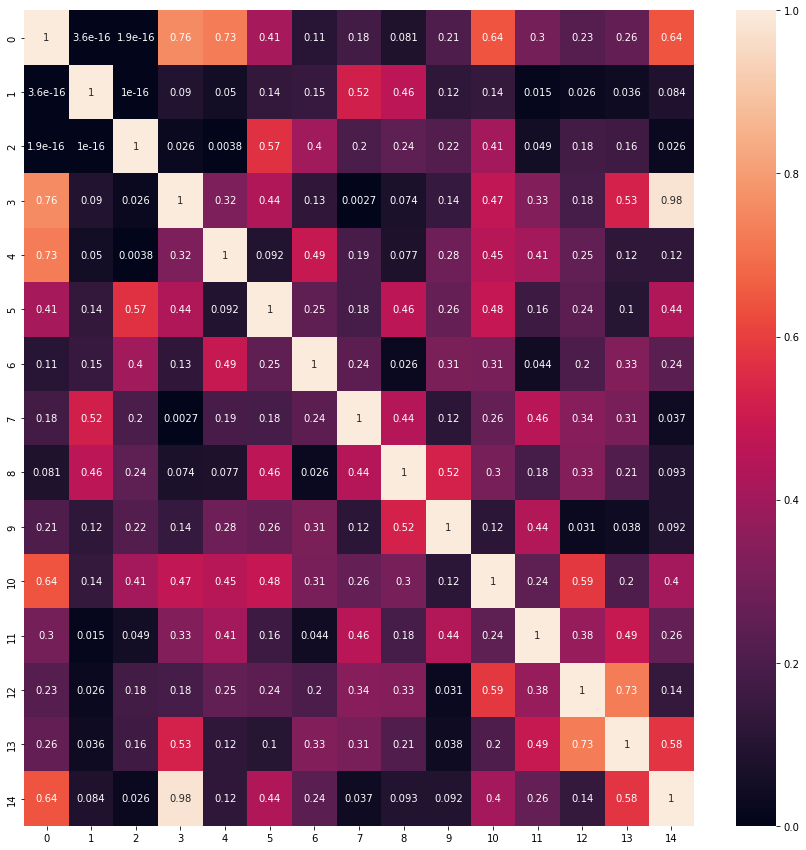

In [22]:
fig, ax = plt.subplots(figsize = (15,15))

sns.heatmap(abs(ct_test_final_df.corr()),annot=True, ax=ax)

### Dummy Model

In [24]:
#Build a dummy model pipeline

dummy_model_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('dummy_mod',DummyRegressor())
])

dummy_model = dummy_model_pipe.fit(X_train,y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [26]:
dummy_modelCV = ModelWithCV(dummy_model_pipe,model_name = 'dummy_mod', X=X_train,y=y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [28]:
dummy_modelCV.print_cv_summary()

CV Results for `dummy_mod` model:
            -0.09730 ± 0.16507 R_squared
        


### Linear Regression

### GradientBoostingRegressor

In [29]:
GBR_model_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('GBR',GradientBoostingRegressor(random_state=42))
])

GBR_model = GBR_model_pipe.fit(X_train,y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [30]:
GBR_pipe = ModelWithCV(GBR_model_pipe,model_name = 'GBR', X=X_train,y=y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [31]:
GBR_pipe.print_cv_summary()

CV Results for `GBR` model:
            0.17293 ± 0.36045 R_squared
        


### Catboost Regressor

In [32]:
catboost_model_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('catboost',CatBoostRegressor(random_seed=42))
])

catboost_model_pipe.fit(X_train,y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.076075
0:	learn: 12.4557434	total: 186ms	remaining: 3m 5s
1:	learn: 12.2195065	total: 193ms	remaining: 1m 36s
2:	learn: 12.0278891	total: 201ms	remaining: 1m 6s
3:	learn: 11.8555841	total: 209ms	remaining: 52s
4:	learn: 11.6927678	total: 217ms	remaining: 43.2s
5:	learn: 11.5300362	total: 223ms	remaining: 36.9s
6:	learn: 11.3942079	total: 229ms	remaining: 32.4s
7:	learn: 11.2702913	total: 234ms	remaining: 29.1s
8:	learn: 11.1522792	total: 240ms	remaining: 26.4s
9:	learn: 11.0529175	total: 245ms	remaining: 24.3s
10:	learn: 10.9567380	total: 252ms	remaining: 22.6s
11:	learn: 10.8650715	total: 258ms	remaining: 21.2s
12:	learn: 10.7839164	total: 264ms	remaining: 20.1s
13:	learn: 10.7069648	total: 271ms	remaining: 19.1s
14:	learn: 10.6331123	total: 277ms	remaining: 18.2s
15:	learn: 10.5571169	total: 282ms	remaining: 17.4s
16:	learn: 10.4870041	total: 288ms	remaining: 16.6s
17:	learn: 10.4224227	total: 293ms	remaining: 16s
18:	learn: 10.3646959	total: 299ms	remaining: 1

166:	learn: 7.9653862	total: 1.44s	remaining: 7.19s
167:	learn: 7.9590487	total: 1.45s	remaining: 7.18s
168:	learn: 7.9540391	total: 1.46s	remaining: 7.17s
169:	learn: 7.9473084	total: 1.47s	remaining: 7.16s
170:	learn: 7.9385300	total: 1.48s	remaining: 7.16s
171:	learn: 7.9337370	total: 1.48s	remaining: 7.14s
172:	learn: 7.9274870	total: 1.49s	remaining: 7.13s
173:	learn: 7.9208255	total: 1.5s	remaining: 7.12s
174:	learn: 7.9155856	total: 1.51s	remaining: 7.11s
175:	learn: 7.9100610	total: 1.52s	remaining: 7.1s
176:	learn: 7.9055604	total: 1.52s	remaining: 7.09s
177:	learn: 7.9007693	total: 1.53s	remaining: 7.08s
178:	learn: 7.8945335	total: 1.54s	remaining: 7.07s
179:	learn: 7.8891283	total: 1.55s	remaining: 7.05s
180:	learn: 7.8849511	total: 1.56s	remaining: 7.04s
181:	learn: 7.8790640	total: 1.57s	remaining: 7.04s
182:	learn: 7.8776206	total: 1.57s	remaining: 7.03s
183:	learn: 7.8674758	total: 1.58s	remaining: 7.01s
184:	learn: 7.8599905	total: 1.59s	remaining: 7.01s
185:	learn: 7.

333:	learn: 7.1803716	total: 2.88s	remaining: 5.74s
334:	learn: 7.1757384	total: 2.89s	remaining: 5.73s
335:	learn: 7.1722016	total: 2.9s	remaining: 5.72s
336:	learn: 7.1694187	total: 2.92s	remaining: 5.75s
337:	learn: 7.1647844	total: 2.94s	remaining: 5.75s
338:	learn: 7.1621182	total: 2.94s	remaining: 5.74s
339:	learn: 7.1603093	total: 2.95s	remaining: 5.73s
340:	learn: 7.1557421	total: 2.96s	remaining: 5.72s
341:	learn: 7.1522470	total: 2.97s	remaining: 5.71s
342:	learn: 7.1480640	total: 2.98s	remaining: 5.7s
343:	learn: 7.1458355	total: 2.98s	remaining: 5.69s
344:	learn: 7.1428340	total: 2.99s	remaining: 5.68s
345:	learn: 7.1415305	total: 3s	remaining: 5.67s
346:	learn: 7.1371387	total: 3.01s	remaining: 5.67s
347:	learn: 7.1337261	total: 3.02s	remaining: 5.66s
348:	learn: 7.1306568	total: 3.03s	remaining: 5.65s
349:	learn: 7.1267687	total: 3.04s	remaining: 5.64s
350:	learn: 7.1220902	total: 3.04s	remaining: 5.63s
351:	learn: 7.1198867	total: 3.05s	remaining: 5.62s
352:	learn: 7.118

504:	learn: 6.7609990	total: 4.34s	remaining: 4.25s
505:	learn: 6.7588909	total: 4.35s	remaining: 4.24s
506:	learn: 6.7563948	total: 4.36s	remaining: 4.24s
507:	learn: 6.7537052	total: 4.37s	remaining: 4.23s
508:	learn: 6.7521302	total: 4.38s	remaining: 4.22s
509:	learn: 6.7505087	total: 4.38s	remaining: 4.21s
510:	learn: 6.7488240	total: 4.39s	remaining: 4.2s
511:	learn: 6.7471655	total: 4.4s	remaining: 4.19s
512:	learn: 6.7441262	total: 4.41s	remaining: 4.18s
513:	learn: 6.7427697	total: 4.42s	remaining: 4.17s
514:	learn: 6.7414530	total: 4.42s	remaining: 4.17s
515:	learn: 6.7397010	total: 4.43s	remaining: 4.16s
516:	learn: 6.7356087	total: 4.44s	remaining: 4.15s
517:	learn: 6.7336542	total: 4.45s	remaining: 4.14s
518:	learn: 6.7304246	total: 4.46s	remaining: 4.13s
519:	learn: 6.7284251	total: 4.46s	remaining: 4.12s
520:	learn: 6.7273333	total: 4.47s	remaining: 4.11s
521:	learn: 6.7262543	total: 4.48s	remaining: 4.1s
522:	learn: 6.7244281	total: 4.49s	remaining: 4.09s
523:	learn: 6.7

671:	learn: 6.4733003	total: 5.78s	remaining: 2.82s
672:	learn: 6.4720165	total: 5.79s	remaining: 2.81s
673:	learn: 6.4712265	total: 5.8s	remaining: 2.81s
674:	learn: 6.4701215	total: 5.81s	remaining: 2.8s
675:	learn: 6.4687899	total: 5.82s	remaining: 2.79s
676:	learn: 6.4673536	total: 5.83s	remaining: 2.78s
677:	learn: 6.4653948	total: 5.84s	remaining: 2.77s
678:	learn: 6.4635232	total: 5.87s	remaining: 2.77s
679:	learn: 6.4602300	total: 5.88s	remaining: 2.77s
680:	learn: 6.4590780	total: 5.88s	remaining: 2.76s
681:	learn: 6.4570370	total: 5.89s	remaining: 2.75s
682:	learn: 6.4558271	total: 5.9s	remaining: 2.74s
683:	learn: 6.4551991	total: 5.91s	remaining: 2.73s
684:	learn: 6.4536124	total: 5.92s	remaining: 2.72s
685:	learn: 6.4524771	total: 5.92s	remaining: 2.71s
686:	learn: 6.4509519	total: 5.93s	remaining: 2.7s
687:	learn: 6.4499209	total: 5.94s	remaining: 2.69s
688:	learn: 6.4485109	total: 5.95s	remaining: 2.69s
689:	learn: 6.4473200	total: 5.96s	remaining: 2.68s
690:	learn: 6.44

841:	learn: 6.2619549	total: 7.24s	remaining: 1.36s
842:	learn: 6.2609153	total: 7.25s	remaining: 1.35s
843:	learn: 6.2600156	total: 7.26s	remaining: 1.34s
844:	learn: 6.2590196	total: 7.27s	remaining: 1.33s
845:	learn: 6.2582841	total: 7.27s	remaining: 1.32s
846:	learn: 6.2574872	total: 7.28s	remaining: 1.31s
847:	learn: 6.2568794	total: 7.29s	remaining: 1.31s
848:	learn: 6.2562125	total: 7.3s	remaining: 1.3s
849:	learn: 6.2553811	total: 7.31s	remaining: 1.29s
850:	learn: 6.2538309	total: 7.32s	remaining: 1.28s
851:	learn: 6.2535723	total: 7.32s	remaining: 1.27s
852:	learn: 6.2520732	total: 7.33s	remaining: 1.26s
853:	learn: 6.2510876	total: 7.34s	remaining: 1.25s
854:	learn: 6.2504784	total: 7.35s	remaining: 1.25s
855:	learn: 6.2495032	total: 7.36s	remaining: 1.24s
856:	learn: 6.2489258	total: 7.37s	remaining: 1.23s
857:	learn: 6.2474884	total: 7.38s	remaining: 1.22s
858:	learn: 6.2455349	total: 7.38s	remaining: 1.21s
859:	learn: 6.2438640	total: 7.39s	remaining: 1.2s
860:	learn: 6.2

Pipeline(steps=[('ct1',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001BF8E748C10>)),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(max_depth=10,
                                                                                                                    max_samples=0.5,
                                                                                                                    n_estimators=4,
                                                         

In [33]:
catboost_model = ModelWithCV(catboost_model_pipe,model_name = 'catboost', X=X_train,y=y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 12.9011616	total: 5.79ms	remaining: 5.78s
1:	learn: 12.6675687	total: 10.9ms	remaining: 5.46s
2:	learn: 12.4526476	total: 16.3ms	remaining: 5.42s
3:	learn: 12.2711169	total: 21.3ms	remaining: 5.31s
4:	learn: 12.0910767	total: 26.6ms	remaining: 5.3s
5:	learn: 11.9363495	total: 31.7ms	remaining: 5.25s
6:	learn: 11.7842784	total: 36.5ms	remaining: 5.18s
7:	learn: 11.6449428	total: 41.5ms	remaining: 5.14s
8:	learn: 11.5350789	total: 46.1ms	remaining: 5.07s
9:	learn: 11.4211548	total: 51.1ms	remaining: 5.05s
10:	learn: 11.3173309	total: 55.9ms	remaining: 5.03s
11:	learn: 11.2227504	total: 61ms	remaining: 5.02s
12:	learn: 11.1185473	total: 65.7ms	remaining: 4.99s
13:	learn: 11.0329780	total: 70.3ms	remaining: 4.95s
14:	learn: 10.9489837	total: 76.3ms	remaining: 5.01s
15:	learn: 10.8610063	total: 81.7ms	remaining: 5.02s
16:	learn: 10.7803513	total: 86.8ms	remaining: 5.02s
17:	learn: 10.7237153	total: 91.7ms	remaining: 5s
18:	learn: 10.6687079	total: 96.4

169:	learn: 8.2937276	total: 1s	remaining: 4.91s
170:	learn: 8.2859803	total: 1.01s	remaining: 4.91s
171:	learn: 8.2791155	total: 1.02s	remaining: 4.91s
172:	learn: 8.2714128	total: 1.03s	remaining: 4.92s
173:	learn: 8.2662876	total: 1.03s	remaining: 4.92s
174:	learn: 8.2551084	total: 1.04s	remaining: 4.92s
175:	learn: 8.2476791	total: 1.05s	remaining: 4.92s
176:	learn: 8.2418726	total: 1.06s	remaining: 4.92s
177:	learn: 8.2321478	total: 1.06s	remaining: 4.92s
178:	learn: 8.2245666	total: 1.07s	remaining: 4.92s
179:	learn: 8.2190253	total: 1.08s	remaining: 4.92s
180:	learn: 8.2138495	total: 1.09s	remaining: 4.92s
181:	learn: 8.2080274	total: 1.09s	remaining: 4.92s
182:	learn: 8.1932697	total: 1.1s	remaining: 4.92s
183:	learn: 8.1847866	total: 1.11s	remaining: 4.92s
184:	learn: 8.1791469	total: 1.12s	remaining: 4.92s
185:	learn: 8.1727049	total: 1.12s	remaining: 4.92s
186:	learn: 8.1614408	total: 1.13s	remaining: 4.92s
187:	learn: 8.1551724	total: 1.14s	remaining: 4.92s
188:	learn: 8.14

335:	learn: 7.4583575	total: 2.24s	remaining: 4.43s
336:	learn: 7.4559409	total: 2.25s	remaining: 4.43s
337:	learn: 7.4516977	total: 2.26s	remaining: 4.42s
338:	learn: 7.4483152	total: 2.27s	remaining: 4.42s
339:	learn: 7.4452546	total: 2.27s	remaining: 4.42s
340:	learn: 7.4420669	total: 2.28s	remaining: 4.41s
341:	learn: 7.4379106	total: 2.29s	remaining: 4.41s
342:	learn: 7.4356291	total: 2.3s	remaining: 4.4s
343:	learn: 7.4336188	total: 2.31s	remaining: 4.4s
344:	learn: 7.4309019	total: 2.31s	remaining: 4.39s
345:	learn: 7.4282544	total: 2.32s	remaining: 4.39s
346:	learn: 7.4253140	total: 2.33s	remaining: 4.38s
347:	learn: 7.4160543	total: 2.33s	remaining: 4.37s
348:	learn: 7.4131550	total: 2.34s	remaining: 4.37s
349:	learn: 7.4109476	total: 2.35s	remaining: 4.36s
350:	learn: 7.4092907	total: 2.36s	remaining: 4.36s
351:	learn: 7.4061615	total: 2.36s	remaining: 4.35s
352:	learn: 7.4037254	total: 2.37s	remaining: 4.34s
353:	learn: 7.4017346	total: 2.38s	remaining: 4.34s
354:	learn: 7.3

502:	learn: 7.0388879	total: 3.5s	remaining: 3.46s
503:	learn: 7.0363875	total: 3.51s	remaining: 3.45s
504:	learn: 7.0344659	total: 3.52s	remaining: 3.45s
505:	learn: 7.0334525	total: 3.53s	remaining: 3.44s
506:	learn: 7.0307613	total: 3.53s	remaining: 3.44s
507:	learn: 7.0279712	total: 3.54s	remaining: 3.43s
508:	learn: 7.0249245	total: 3.55s	remaining: 3.42s
509:	learn: 7.0227077	total: 3.56s	remaining: 3.42s
510:	learn: 7.0214157	total: 3.56s	remaining: 3.41s
511:	learn: 7.0195863	total: 3.57s	remaining: 3.4s
512:	learn: 7.0179925	total: 3.58s	remaining: 3.4s
513:	learn: 7.0166678	total: 3.59s	remaining: 3.39s
514:	learn: 7.0155778	total: 3.6s	remaining: 3.38s
515:	learn: 7.0145976	total: 3.6s	remaining: 3.38s
516:	learn: 7.0123661	total: 3.61s	remaining: 3.37s
517:	learn: 7.0092064	total: 3.62s	remaining: 3.37s
518:	learn: 7.0073005	total: 3.63s	remaining: 3.36s
519:	learn: 7.0059433	total: 3.63s	remaining: 3.35s
520:	learn: 7.0045195	total: 3.64s	remaining: 3.35s
521:	learn: 7.001

667:	learn: 6.7617915	total: 4.73s	remaining: 2.35s
668:	learn: 6.7604766	total: 4.74s	remaining: 2.34s
669:	learn: 6.7596993	total: 4.75s	remaining: 2.34s
670:	learn: 6.7586222	total: 4.75s	remaining: 2.33s
671:	learn: 6.7572387	total: 4.76s	remaining: 2.32s
672:	learn: 6.7547972	total: 4.77s	remaining: 2.32s
673:	learn: 6.7540695	total: 4.78s	remaining: 2.31s
674:	learn: 6.7525337	total: 4.78s	remaining: 2.3s
675:	learn: 6.7507258	total: 4.79s	remaining: 2.3s
676:	learn: 6.7499715	total: 4.8s	remaining: 2.29s
677:	learn: 6.7486570	total: 4.8s	remaining: 2.28s
678:	learn: 6.7465188	total: 4.81s	remaining: 2.27s
679:	learn: 6.7451859	total: 4.82s	remaining: 2.27s
680:	learn: 6.7439932	total: 4.83s	remaining: 2.26s
681:	learn: 6.7432916	total: 4.83s	remaining: 2.25s
682:	learn: 6.7417538	total: 4.84s	remaining: 2.25s
683:	learn: 6.7404050	total: 4.85s	remaining: 2.24s
684:	learn: 6.7388118	total: 4.86s	remaining: 2.23s
685:	learn: 6.7377970	total: 4.86s	remaining: 2.23s
686:	learn: 6.73

833:	learn: 6.5518938	total: 5.99s	remaining: 1.19s
834:	learn: 6.5510835	total: 6s	remaining: 1.19s
835:	learn: 6.5504608	total: 6.01s	remaining: 1.18s
836:	learn: 6.5497010	total: 6.01s	remaining: 1.17s
837:	learn: 6.5483246	total: 6.02s	remaining: 1.16s
838:	learn: 6.5462598	total: 6.03s	remaining: 1.16s
839:	learn: 6.5456481	total: 6.04s	remaining: 1.15s
840:	learn: 6.5450679	total: 6.04s	remaining: 1.14s
841:	learn: 6.5444838	total: 6.05s	remaining: 1.14s
842:	learn: 6.5436059	total: 6.06s	remaining: 1.13s
843:	learn: 6.5419852	total: 6.07s	remaining: 1.12s
844:	learn: 6.5409005	total: 6.07s	remaining: 1.11s
845:	learn: 6.5402439	total: 6.08s	remaining: 1.11s
846:	learn: 6.5390864	total: 6.09s	remaining: 1.1s
847:	learn: 6.5382959	total: 6.09s	remaining: 1.09s
848:	learn: 6.5375191	total: 6.1s	remaining: 1.08s
849:	learn: 6.5360328	total: 6.11s	remaining: 1.08s
850:	learn: 6.5352750	total: 6.12s	remaining: 1.07s
851:	learn: 6.5342810	total: 6.13s	remaining: 1.06s
852:	learn: 6.533

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 13.1885101	total: 5.89ms	remaining: 5.89s
1:	learn: 12.9503884	total: 10.9ms	remaining: 5.46s
2:	learn: 12.7492475	total: 18.5ms	remaining: 6.15s
3:	learn: 12.5677804	total: 23.8ms	remaining: 5.92s
4:	learn: 12.4015409	total: 28.9ms	remaining: 5.75s
5:	learn: 12.2378153	total: 36.7ms	remaining: 6.07s
6:	learn: 12.1110177	total: 41.9ms	remaining: 5.94s
7:	learn: 11.9857785	total: 49.8ms	remaining: 6.17s
8:	learn: 11.8545248	total: 55.3ms	remaining: 6.09s
9:	learn: 11.7301891	total: 60.7ms	remaining: 6.01s
10:	learn: 11.6255163	total: 69ms	remaining: 6.2s
11:	learn: 11.5325486	total: 74.2ms	remaining: 6.11s
12:	learn: 11.4378033	total: 82ms	remaining: 6.22s
13:	learn: 11.3512205	total: 87.7ms	remaining: 6.18s
14:	learn: 11.2690365	total: 93.4ms	remaining: 6.13s
15:	learn: 11.1998530	total: 101ms	remaining: 6.19s
16:	learn: 11.1229754	total: 106ms	remaining: 6.13s
17:	learn: 11.0428541	total: 115ms	remaining: 6.28s
18:	learn: 10.9789305	total: 121ms	

170:	learn: 8.3513731	total: 1.4s	remaining: 6.78s
171:	learn: 8.3440289	total: 1.41s	remaining: 6.78s
172:	learn: 8.3299188	total: 1.42s	remaining: 6.79s
173:	learn: 8.3220374	total: 1.43s	remaining: 6.78s
174:	learn: 8.3161754	total: 1.44s	remaining: 6.78s
175:	learn: 8.3040249	total: 1.45s	remaining: 6.77s
176:	learn: 8.2984264	total: 1.46s	remaining: 6.77s
177:	learn: 8.2924999	total: 1.47s	remaining: 6.77s
178:	learn: 8.2870529	total: 1.47s	remaining: 6.76s
179:	learn: 8.2811809	total: 1.48s	remaining: 6.76s
180:	learn: 8.2732533	total: 1.49s	remaining: 6.76s
181:	learn: 8.2651305	total: 1.5s	remaining: 6.77s
182:	learn: 8.2582285	total: 1.52s	remaining: 6.77s
183:	learn: 8.2489786	total: 1.52s	remaining: 6.76s
184:	learn: 8.2437607	total: 1.53s	remaining: 6.76s
185:	learn: 8.2339406	total: 1.54s	remaining: 6.75s
186:	learn: 8.2251930	total: 1.55s	remaining: 6.75s
187:	learn: 8.2189908	total: 1.56s	remaining: 6.74s
188:	learn: 8.2140045	total: 1.57s	remaining: 6.73s
189:	learn: 8.

331:	learn: 7.4898216	total: 2.84s	remaining: 5.71s
332:	learn: 7.4865971	total: 2.85s	remaining: 5.71s
333:	learn: 7.4838159	total: 2.86s	remaining: 5.7s
334:	learn: 7.4805240	total: 2.87s	remaining: 5.69s
335:	learn: 7.4776533	total: 2.88s	remaining: 5.68s
336:	learn: 7.4736685	total: 2.88s	remaining: 5.68s
337:	learn: 7.4700045	total: 2.89s	remaining: 5.67s
338:	learn: 7.4677825	total: 2.9s	remaining: 5.66s
339:	learn: 7.4631888	total: 2.91s	remaining: 5.65s
340:	learn: 7.4588650	total: 2.92s	remaining: 5.64s
341:	learn: 7.4573557	total: 2.93s	remaining: 5.63s
342:	learn: 7.4538430	total: 2.94s	remaining: 5.63s
343:	learn: 7.4505326	total: 2.94s	remaining: 5.61s
344:	learn: 7.4464243	total: 2.95s	remaining: 5.61s
345:	learn: 7.4422601	total: 2.96s	remaining: 5.6s
346:	learn: 7.4389700	total: 2.97s	remaining: 5.59s
347:	learn: 7.4355360	total: 2.98s	remaining: 5.58s
348:	learn: 7.4318373	total: 2.99s	remaining: 5.57s
349:	learn: 7.4280038	total: 3s	remaining: 5.57s
350:	learn: 7.4232

497:	learn: 7.0570790	total: 4.31s	remaining: 4.35s
498:	learn: 7.0559362	total: 4.32s	remaining: 4.34s
499:	learn: 7.0546734	total: 4.33s	remaining: 4.33s
500:	learn: 7.0528209	total: 4.34s	remaining: 4.32s
501:	learn: 7.0509427	total: 4.35s	remaining: 4.31s
502:	learn: 7.0489955	total: 4.36s	remaining: 4.3s
503:	learn: 7.0485004	total: 4.36s	remaining: 4.29s
504:	learn: 7.0466779	total: 4.37s	remaining: 4.29s
505:	learn: 7.0450172	total: 4.38s	remaining: 4.28s
506:	learn: 7.0432348	total: 4.39s	remaining: 4.27s
507:	learn: 7.0381098	total: 4.4s	remaining: 4.26s
508:	learn: 7.0367405	total: 4.41s	remaining: 4.25s
509:	learn: 7.0352938	total: 4.41s	remaining: 4.24s
510:	learn: 7.0334281	total: 4.42s	remaining: 4.23s
511:	learn: 7.0322285	total: 4.43s	remaining: 4.22s
512:	learn: 7.0291606	total: 4.44s	remaining: 4.21s
513:	learn: 7.0274714	total: 4.45s	remaining: 4.21s
514:	learn: 7.0254802	total: 4.46s	remaining: 4.2s
515:	learn: 7.0234882	total: 4.46s	remaining: 4.19s
516:	learn: 7.0

676:	learn: 6.7417831	total: 5.95s	remaining: 2.84s
677:	learn: 6.7403676	total: 5.96s	remaining: 2.83s
678:	learn: 6.7377319	total: 5.97s	remaining: 2.82s
679:	learn: 6.7366262	total: 6s	remaining: 2.82s
680:	learn: 6.7355867	total: 6.01s	remaining: 2.81s
681:	learn: 6.7347734	total: 6.02s	remaining: 2.81s
682:	learn: 6.7332125	total: 6.03s	remaining: 2.8s
683:	learn: 6.7317584	total: 6.04s	remaining: 2.79s
684:	learn: 6.7310355	total: 6.05s	remaining: 2.78s
685:	learn: 6.7297238	total: 6.06s	remaining: 2.77s
686:	learn: 6.7261029	total: 6.06s	remaining: 2.76s
687:	learn: 6.7249298	total: 6.07s	remaining: 2.75s
688:	learn: 6.7237268	total: 6.08s	remaining: 2.75s
689:	learn: 6.7221976	total: 6.09s	remaining: 2.74s
690:	learn: 6.7209120	total: 6.1s	remaining: 2.73s
691:	learn: 6.7190434	total: 6.11s	remaining: 2.72s
692:	learn: 6.7170508	total: 6.12s	remaining: 2.71s
693:	learn: 6.7157440	total: 6.13s	remaining: 2.7s
694:	learn: 6.7146293	total: 6.14s	remaining: 2.69s
695:	learn: 6.7136

841:	learn: 6.5289383	total: 7.43s	remaining: 1.39s
842:	learn: 6.5281843	total: 7.44s	remaining: 1.39s
843:	learn: 6.5263748	total: 7.45s	remaining: 1.38s
844:	learn: 6.5256539	total: 7.46s	remaining: 1.37s
845:	learn: 6.5247102	total: 7.47s	remaining: 1.36s
846:	learn: 6.5238197	total: 7.48s	remaining: 1.35s
847:	learn: 6.5229758	total: 7.48s	remaining: 1.34s
848:	learn: 6.5219729	total: 7.49s	remaining: 1.33s
849:	learn: 6.5209759	total: 7.5s	remaining: 1.32s
850:	learn: 6.5203095	total: 7.51s	remaining: 1.31s
851:	learn: 6.5196507	total: 7.52s	remaining: 1.31s
852:	learn: 6.5190729	total: 7.53s	remaining: 1.3s
853:	learn: 6.5175114	total: 7.54s	remaining: 1.29s
854:	learn: 6.5158717	total: 7.55s	remaining: 1.28s
855:	learn: 6.5150765	total: 7.56s	remaining: 1.27s
856:	learn: 6.5147296	total: 7.57s	remaining: 1.26s
857:	learn: 6.5140041	total: 7.58s	remaining: 1.25s
858:	learn: 6.5133866	total: 7.58s	remaining: 1.24s
859:	learn: 6.5119122	total: 7.59s	remaining: 1.24s
860:	learn: 6.

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 11.8849562	total: 15.8ms	remaining: 15.8s
1:	learn: 11.6153978	total: 20.6ms	remaining: 10.3s
2:	learn: 11.3866090	total: 25.5ms	remaining: 8.46s
3:	learn: 11.1782712	total: 31ms	remaining: 7.72s
4:	learn: 11.0050471	total: 35.6ms	remaining: 7.08s
5:	learn: 10.8160548	total: 40.4ms	remaining: 6.69s
6:	learn: 10.6550714	total: 45.8ms	remaining: 6.5s
7:	learn: 10.5254399	total: 50.9ms	remaining: 6.31s
8:	learn: 10.4046865	total: 55.8ms	remaining: 6.14s
9:	learn: 10.2872455	total: 60.8ms	remaining: 6.02s
10:	learn: 10.1822177	total: 65.5ms	remaining: 5.89s
11:	learn: 10.0898845	total: 70.5ms	remaining: 5.8s
12:	learn: 9.9861000	total: 76.4ms	remaining: 5.8s
13:	learn: 9.9033650	total: 81.2ms	remaining: 5.72s
14:	learn: 9.8288882	total: 85.9ms	remaining: 5.64s
15:	learn: 9.7628268	total: 90.9ms	remaining: 5.59s
16:	learn: 9.6954245	total: 95.8ms	remaining: 5.54s
17:	learn: 9.6244323	total: 100ms	remaining: 5.48s
18:	learn: 9.5475866	total: 106ms	remai

168:	learn: 7.0219503	total: 1.04s	remaining: 5.1s
169:	learn: 7.0087530	total: 1.04s	remaining: 5.1s
170:	learn: 7.0031693	total: 1.05s	remaining: 5.11s
171:	learn: 6.9962966	total: 1.06s	remaining: 5.11s
172:	learn: 6.9895663	total: 1.07s	remaining: 5.1s
173:	learn: 6.9800334	total: 1.07s	remaining: 5.1s
174:	learn: 6.9742780	total: 1.08s	remaining: 5.1s
175:	learn: 6.9604582	total: 1.09s	remaining: 5.09s
176:	learn: 6.9543313	total: 1.09s	remaining: 5.09s
177:	learn: 6.9488452	total: 1.1s	remaining: 5.09s
178:	learn: 6.9421246	total: 1.11s	remaining: 5.09s
179:	learn: 6.9341551	total: 1.12s	remaining: 5.09s
180:	learn: 6.9285061	total: 1.12s	remaining: 5.09s
181:	learn: 6.9157182	total: 1.13s	remaining: 5.08s
182:	learn: 6.9083967	total: 1.14s	remaining: 5.08s
183:	learn: 6.9011250	total: 1.14s	remaining: 5.08s
184:	learn: 6.8932064	total: 1.15s	remaining: 5.07s
185:	learn: 6.8853675	total: 1.16s	remaining: 5.07s
186:	learn: 6.8712910	total: 1.17s	remaining: 5.07s
187:	learn: 6.8642

337:	learn: 6.1322296	total: 2.28s	remaining: 4.47s
338:	learn: 6.1287985	total: 2.29s	remaining: 4.47s
339:	learn: 6.1254641	total: 2.3s	remaining: 4.46s
340:	learn: 6.1227810	total: 2.31s	remaining: 4.46s
341:	learn: 6.1172584	total: 2.31s	remaining: 4.45s
342:	learn: 6.1127852	total: 2.32s	remaining: 4.45s
343:	learn: 6.1093395	total: 2.33s	remaining: 4.44s
344:	learn: 6.1051039	total: 2.34s	remaining: 4.44s
345:	learn: 6.1004194	total: 2.34s	remaining: 4.43s
346:	learn: 6.0977201	total: 2.35s	remaining: 4.43s
347:	learn: 6.0940956	total: 2.36s	remaining: 4.42s
348:	learn: 6.0910645	total: 2.37s	remaining: 4.42s
349:	learn: 6.0869350	total: 2.38s	remaining: 4.41s
350:	learn: 6.0814588	total: 2.38s	remaining: 4.41s
351:	learn: 6.0781035	total: 2.39s	remaining: 4.4s
352:	learn: 6.0733429	total: 2.4s	remaining: 4.4s
353:	learn: 6.0700850	total: 2.41s	remaining: 4.39s
354:	learn: 6.0645852	total: 2.41s	remaining: 4.39s
355:	learn: 6.0613314	total: 2.42s	remaining: 4.38s
356:	learn: 6.05

502:	learn: 5.6528215	total: 3.53s	remaining: 3.49s
503:	learn: 5.6512880	total: 3.54s	remaining: 3.48s
504:	learn: 5.6490388	total: 3.55s	remaining: 3.48s
505:	learn: 5.6468595	total: 3.56s	remaining: 3.47s
506:	learn: 5.6449003	total: 3.56s	remaining: 3.47s
507:	learn: 5.6435706	total: 3.57s	remaining: 3.46s
508:	learn: 5.6414339	total: 3.58s	remaining: 3.45s
509:	learn: 5.6395802	total: 3.59s	remaining: 3.45s
510:	learn: 5.6359001	total: 3.6s	remaining: 3.44s
511:	learn: 5.6335163	total: 3.6s	remaining: 3.43s
512:	learn: 5.6302607	total: 3.61s	remaining: 3.43s
513:	learn: 5.6285998	total: 3.62s	remaining: 3.42s
514:	learn: 5.6267226	total: 3.63s	remaining: 3.42s
515:	learn: 5.6246845	total: 3.63s	remaining: 3.41s
516:	learn: 5.6216156	total: 3.64s	remaining: 3.4s
517:	learn: 5.6178415	total: 3.65s	remaining: 3.4s
518:	learn: 5.6155568	total: 3.66s	remaining: 3.39s
519:	learn: 5.6136289	total: 3.66s	remaining: 3.38s
520:	learn: 5.6022632	total: 3.67s	remaining: 3.38s
521:	learn: 5.60

670:	learn: 5.2760535	total: 4.8s	remaining: 2.35s
671:	learn: 5.2746084	total: 4.81s	remaining: 2.35s
672:	learn: 5.2716574	total: 4.82s	remaining: 2.34s
673:	learn: 5.2693481	total: 4.82s	remaining: 2.33s
674:	learn: 5.2683420	total: 4.83s	remaining: 2.33s
675:	learn: 5.2671026	total: 4.84s	remaining: 2.32s
676:	learn: 5.2658596	total: 4.85s	remaining: 2.31s
677:	learn: 5.2641443	total: 4.85s	remaining: 2.31s
678:	learn: 5.2629117	total: 4.86s	remaining: 2.3s
679:	learn: 5.2615858	total: 4.87s	remaining: 2.29s
680:	learn: 5.2604076	total: 4.88s	remaining: 2.28s
681:	learn: 5.2590097	total: 4.88s	remaining: 2.28s
682:	learn: 5.2574657	total: 4.89s	remaining: 2.27s
683:	learn: 5.2561877	total: 4.9s	remaining: 2.26s
684:	learn: 5.2543941	total: 4.91s	remaining: 2.26s
685:	learn: 5.2521510	total: 4.91s	remaining: 2.25s
686:	learn: 5.2498481	total: 4.92s	remaining: 2.24s
687:	learn: 5.2474626	total: 4.93s	remaining: 2.23s
688:	learn: 5.2460155	total: 4.94s	remaining: 2.23s
689:	learn: 5.2

835:	learn: 5.0088095	total: 6.05s	remaining: 1.19s
836:	learn: 5.0074431	total: 6.06s	remaining: 1.18s
837:	learn: 5.0060299	total: 6.07s	remaining: 1.17s
838:	learn: 5.0045043	total: 6.08s	remaining: 1.17s
839:	learn: 5.0033402	total: 6.09s	remaining: 1.16s
840:	learn: 5.0021645	total: 6.09s	remaining: 1.15s
841:	learn: 5.0016103	total: 6.1s	remaining: 1.14s
842:	learn: 4.9998790	total: 6.11s	remaining: 1.14s
843:	learn: 4.9965780	total: 6.12s	remaining: 1.13s
844:	learn: 4.9945234	total: 6.12s	remaining: 1.12s
845:	learn: 4.9927369	total: 6.13s	remaining: 1.11s
846:	learn: 4.9916688	total: 6.14s	remaining: 1.11s
847:	learn: 4.9900987	total: 6.14s	remaining: 1.1s
848:	learn: 4.9886627	total: 6.15s	remaining: 1.09s
849:	learn: 4.9878307	total: 6.16s	remaining: 1.09s
850:	learn: 4.9861523	total: 6.17s	remaining: 1.08s
851:	learn: 4.9850425	total: 6.17s	remaining: 1.07s
852:	learn: 4.9841904	total: 6.18s	remaining: 1.06s
853:	learn: 4.9833332	total: 6.19s	remaining: 1.06s
854:	learn: 4.

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 11.9400945	total: 20.7ms	remaining: 20.7s
1:	learn: 11.7172611	total: 25.9ms	remaining: 12.9s
2:	learn: 11.5410955	total: 30.7ms	remaining: 10.2s
3:	learn: 11.3597687	total: 35.5ms	remaining: 8.85s
4:	learn: 11.2033291	total: 40.7ms	remaining: 8.1s
5:	learn: 11.0599356	total: 45.5ms	remaining: 7.54s
6:	learn: 10.9350781	total: 50.2ms	remaining: 7.13s
7:	learn: 10.8069759	total: 56ms	remaining: 6.94s
8:	learn: 10.7002739	total: 60.5ms	remaining: 6.66s
9:	learn: 10.6016663	total: 65.1ms	remaining: 6.45s
10:	learn: 10.5097231	total: 70.3ms	remaining: 6.32s
11:	learn: 10.4365373	total: 75ms	remaining: 6.17s
12:	learn: 10.3571257	total: 79.8ms	remaining: 6.06s
13:	learn: 10.2795547	total: 85.1ms	remaining: 5.99s
14:	learn: 10.2197346	total: 89.8ms	remaining: 5.9s
15:	learn: 10.1451032	total: 94.7ms	remaining: 5.82s
16:	learn: 10.0830567	total: 99.8ms	remaining: 5.77s
17:	learn: 10.0234635	total: 105ms	remaining: 5.71s
18:	learn: 9.9687644	total: 109ms	

163:	learn: 7.7960813	total: 1.03s	remaining: 5.26s
164:	learn: 7.7888869	total: 1.04s	remaining: 5.26s
165:	learn: 7.7848311	total: 1.05s	remaining: 5.26s
166:	learn: 7.7805593	total: 1.05s	remaining: 5.26s
167:	learn: 7.7747205	total: 1.06s	remaining: 5.26s
168:	learn: 7.7681161	total: 1.07s	remaining: 5.26s
169:	learn: 7.7640984	total: 1.08s	remaining: 5.25s
170:	learn: 7.7554009	total: 1.08s	remaining: 5.26s
171:	learn: 7.7499579	total: 1.09s	remaining: 5.25s
172:	learn: 7.7400282	total: 1.1s	remaining: 5.25s
173:	learn: 7.7346832	total: 1.1s	remaining: 5.25s
174:	learn: 7.7294382	total: 1.11s	remaining: 5.25s
175:	learn: 7.7233045	total: 1.12s	remaining: 5.25s
176:	learn: 7.7169457	total: 1.13s	remaining: 5.25s
177:	learn: 7.7089667	total: 1.14s	remaining: 5.25s
178:	learn: 7.6989014	total: 1.14s	remaining: 5.24s
179:	learn: 7.6933773	total: 1.15s	remaining: 5.24s
180:	learn: 7.6832793	total: 1.16s	remaining: 5.24s
181:	learn: 7.6785363	total: 1.17s	remaining: 5.24s
182:	learn: 7.

332:	learn: 7.0451855	total: 2.29s	remaining: 4.59s
333:	learn: 7.0429585	total: 2.3s	remaining: 4.59s
334:	learn: 7.0412135	total: 2.31s	remaining: 4.58s
335:	learn: 7.0386881	total: 2.32s	remaining: 4.58s
336:	learn: 7.0344833	total: 2.32s	remaining: 4.57s
337:	learn: 7.0327500	total: 2.33s	remaining: 4.57s
338:	learn: 7.0297897	total: 2.34s	remaining: 4.56s
339:	learn: 7.0270923	total: 2.35s	remaining: 4.55s
340:	learn: 7.0243083	total: 2.35s	remaining: 4.55s
341:	learn: 7.0221234	total: 2.36s	remaining: 4.54s
342:	learn: 7.0202888	total: 2.37s	remaining: 4.54s
343:	learn: 7.0156033	total: 2.38s	remaining: 4.53s
344:	learn: 7.0125652	total: 2.38s	remaining: 4.52s
345:	learn: 7.0108614	total: 2.39s	remaining: 4.52s
346:	learn: 7.0074094	total: 2.4s	remaining: 4.51s
347:	learn: 7.0057192	total: 2.4s	remaining: 4.51s
348:	learn: 7.0028244	total: 2.41s	remaining: 4.5s
349:	learn: 7.0013441	total: 2.42s	remaining: 4.49s
350:	learn: 6.9967387	total: 2.43s	remaining: 4.49s
351:	learn: 6.99

498:	learn: 6.6590187	total: 3.53s	remaining: 3.55s
499:	learn: 6.6573209	total: 3.54s	remaining: 3.54s
500:	learn: 6.6562144	total: 3.55s	remaining: 3.53s
501:	learn: 6.6530231	total: 3.56s	remaining: 3.53s
502:	learn: 6.6505232	total: 3.56s	remaining: 3.52s
503:	learn: 6.6466753	total: 3.57s	remaining: 3.52s
504:	learn: 6.6450082	total: 3.58s	remaining: 3.51s
505:	learn: 6.6427748	total: 3.59s	remaining: 3.5s
506:	learn: 6.6404572	total: 3.59s	remaining: 3.49s
507:	learn: 6.6388187	total: 3.6s	remaining: 3.49s
508:	learn: 6.6370488	total: 3.61s	remaining: 3.48s
509:	learn: 6.6335293	total: 3.62s	remaining: 3.47s
510:	learn: 6.6311798	total: 3.62s	remaining: 3.47s
511:	learn: 6.6299505	total: 3.63s	remaining: 3.46s
512:	learn: 6.6284562	total: 3.64s	remaining: 3.45s
513:	learn: 6.6269364	total: 3.65s	remaining: 3.45s
514:	learn: 6.6254671	total: 3.65s	remaining: 3.44s
515:	learn: 6.6235506	total: 3.66s	remaining: 3.44s
516:	learn: 6.6216408	total: 3.67s	remaining: 3.43s
517:	learn: 6.

665:	learn: 6.4089575	total: 4.79s	remaining: 2.4s
666:	learn: 6.4083038	total: 4.8s	remaining: 2.4s
667:	learn: 6.4071232	total: 4.81s	remaining: 2.39s
668:	learn: 6.4061770	total: 4.82s	remaining: 2.38s
669:	learn: 6.4041491	total: 4.82s	remaining: 2.38s
670:	learn: 6.4036413	total: 4.83s	remaining: 2.37s
671:	learn: 6.4022649	total: 4.84s	remaining: 2.36s
672:	learn: 6.4011789	total: 4.84s	remaining: 2.35s
673:	learn: 6.4005375	total: 4.85s	remaining: 2.35s
674:	learn: 6.3997676	total: 4.86s	remaining: 2.34s
675:	learn: 6.3988181	total: 4.87s	remaining: 2.33s
676:	learn: 6.3978948	total: 4.88s	remaining: 2.33s
677:	learn: 6.3962202	total: 4.88s	remaining: 2.32s
678:	learn: 6.3948032	total: 4.89s	remaining: 2.31s
679:	learn: 6.3929123	total: 4.9s	remaining: 2.3s
680:	learn: 6.3920777	total: 4.91s	remaining: 2.3s
681:	learn: 6.3888409	total: 4.91s	remaining: 2.29s
682:	learn: 6.3877930	total: 4.92s	remaining: 2.28s
683:	learn: 6.3856147	total: 4.93s	remaining: 2.27s
684:	learn: 6.3848

831:	learn: 6.2265291	total: 6.03s	remaining: 1.22s
832:	learn: 6.2253481	total: 6.04s	remaining: 1.21s
833:	learn: 6.2248571	total: 6.05s	remaining: 1.2s
834:	learn: 6.2237184	total: 6.06s	remaining: 1.2s
835:	learn: 6.2229700	total: 6.06s	remaining: 1.19s
836:	learn: 6.2218876	total: 6.07s	remaining: 1.18s
837:	learn: 6.2213314	total: 6.08s	remaining: 1.18s
838:	learn: 6.2203813	total: 6.08s	remaining: 1.17s
839:	learn: 6.2193276	total: 6.09s	remaining: 1.16s
840:	learn: 6.2176536	total: 6.1s	remaining: 1.15s
841:	learn: 6.2169105	total: 6.11s	remaining: 1.15s
842:	learn: 6.2157196	total: 6.11s	remaining: 1.14s
843:	learn: 6.2149885	total: 6.12s	remaining: 1.13s
844:	learn: 6.2140060	total: 6.13s	remaining: 1.12s
845:	learn: 6.2134907	total: 6.13s	remaining: 1.12s
846:	learn: 6.2127645	total: 6.14s	remaining: 1.11s
847:	learn: 6.2121959	total: 6.15s	remaining: 1.1s
848:	learn: 6.2116881	total: 6.16s	remaining: 1.09s
849:	learn: 6.2108619	total: 6.16s	remaining: 1.09s
850:	learn: 6.21

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 12.2322016	total: 5.49ms	remaining: 5.48s
1:	learn: 12.0525663	total: 10.8ms	remaining: 5.39s
2:	learn: 11.8585721	total: 16.1ms	remaining: 5.34s
3:	learn: 11.6957700	total: 21.2ms	remaining: 5.27s
4:	learn: 11.5506020	total: 28.4ms	remaining: 5.64s
5:	learn: 11.4237153	total: 33.2ms	remaining: 5.49s
6:	learn: 11.2960166	total: 38.2ms	remaining: 5.42s
7:	learn: 11.1747358	total: 43.2ms	remaining: 5.36s
8:	learn: 11.0791449	total: 47.9ms	remaining: 5.28s
9:	learn: 10.9894784	total: 52.7ms	remaining: 5.22s
10:	learn: 10.8911632	total: 58.1ms	remaining: 5.22s
11:	learn: 10.8003529	total: 63ms	remaining: 5.18s
12:	learn: 10.7279549	total: 67.9ms	remaining: 5.16s
13:	learn: 10.6586761	total: 73.2ms	remaining: 5.15s
14:	learn: 10.5969437	total: 77.8ms	remaining: 5.11s
15:	learn: 10.5379019	total: 82.9ms	remaining: 5.1s
16:	learn: 10.4702411	total: 88.1ms	remaining: 5.09s
17:	learn: 10.4039357	total: 93.3ms	remaining: 5.09s
18:	learn: 10.3472262	total: 9

172:	learn: 7.8254096	total: 1.01s	remaining: 4.82s
173:	learn: 7.8194414	total: 1.01s	remaining: 4.82s
174:	learn: 7.8105387	total: 1.02s	remaining: 4.83s
175:	learn: 7.7995957	total: 1.03s	remaining: 4.83s
176:	learn: 7.7938854	total: 1.04s	remaining: 4.83s
177:	learn: 7.7878985	total: 1.04s	remaining: 4.83s
178:	learn: 7.7811205	total: 1.05s	remaining: 4.83s
179:	learn: 7.7755676	total: 1.06s	remaining: 4.82s
180:	learn: 7.7668505	total: 1.07s	remaining: 4.83s
181:	learn: 7.7614017	total: 1.07s	remaining: 4.82s
182:	learn: 7.7535937	total: 1.08s	remaining: 4.83s
183:	learn: 7.7441700	total: 1.09s	remaining: 4.83s
184:	learn: 7.7377279	total: 1.1s	remaining: 4.83s
185:	learn: 7.7326367	total: 1.1s	remaining: 4.83s
186:	learn: 7.7262559	total: 1.11s	remaining: 4.83s
187:	learn: 7.7191348	total: 1.12s	remaining: 4.83s
188:	learn: 7.7109795	total: 1.12s	remaining: 4.83s
189:	learn: 7.7034114	total: 1.13s	remaining: 4.83s
190:	learn: 7.6968757	total: 1.14s	remaining: 4.83s
191:	learn: 7.

338:	learn: 7.0027439	total: 2.26s	remaining: 4.4s
339:	learn: 6.9996681	total: 2.27s	remaining: 4.4s
340:	learn: 6.9951901	total: 2.27s	remaining: 4.39s
341:	learn: 6.9920669	total: 2.28s	remaining: 4.39s
342:	learn: 6.9886148	total: 2.29s	remaining: 4.38s
343:	learn: 6.9859912	total: 2.29s	remaining: 4.38s
344:	learn: 6.9829413	total: 2.3s	remaining: 4.37s
345:	learn: 6.9809856	total: 2.31s	remaining: 4.37s
346:	learn: 6.9771103	total: 2.32s	remaining: 4.36s
347:	learn: 6.9723520	total: 2.33s	remaining: 4.36s
348:	learn: 6.9702107	total: 2.33s	remaining: 4.35s
349:	learn: 6.9686949	total: 2.34s	remaining: 4.35s
350:	learn: 6.9658488	total: 2.35s	remaining: 4.34s
351:	learn: 6.9630987	total: 2.35s	remaining: 4.33s
352:	learn: 6.9595487	total: 2.36s	remaining: 4.33s
353:	learn: 6.9564398	total: 2.37s	remaining: 4.32s
354:	learn: 6.9512679	total: 2.38s	remaining: 4.32s
355:	learn: 6.9485046	total: 2.38s	remaining: 4.31s
356:	learn: 6.9415186	total: 2.39s	remaining: 4.31s
357:	learn: 6.9

505:	learn: 6.5711437	total: 3.51s	remaining: 3.43s
506:	learn: 6.5694706	total: 3.52s	remaining: 3.42s
507:	learn: 6.5673494	total: 3.53s	remaining: 3.42s
508:	learn: 6.5646157	total: 3.54s	remaining: 3.41s
509:	learn: 6.5626781	total: 3.55s	remaining: 3.41s
510:	learn: 6.5601407	total: 3.55s	remaining: 3.4s
511:	learn: 6.5579892	total: 3.56s	remaining: 3.39s
512:	learn: 6.5566811	total: 3.57s	remaining: 3.39s
513:	learn: 6.5542969	total: 3.58s	remaining: 3.38s
514:	learn: 6.5524895	total: 3.58s	remaining: 3.37s
515:	learn: 6.5511657	total: 3.59s	remaining: 3.37s
516:	learn: 6.5491042	total: 3.6s	remaining: 3.36s
517:	learn: 6.5477625	total: 3.61s	remaining: 3.36s
518:	learn: 6.5459504	total: 3.61s	remaining: 3.35s
519:	learn: 6.5440272	total: 3.62s	remaining: 3.34s
520:	learn: 6.5414297	total: 3.63s	remaining: 3.34s
521:	learn: 6.5386259	total: 3.64s	remaining: 3.33s
522:	learn: 6.5366841	total: 3.65s	remaining: 3.33s
523:	learn: 6.5342341	total: 3.65s	remaining: 3.32s
524:	learn: 6.

672:	learn: 6.2904636	total: 4.77s	remaining: 2.32s
673:	learn: 6.2894754	total: 4.78s	remaining: 2.31s
674:	learn: 6.2886139	total: 4.79s	remaining: 2.3s
675:	learn: 6.2869722	total: 4.79s	remaining: 2.3s
676:	learn: 6.2855344	total: 4.8s	remaining: 2.29s
677:	learn: 6.2840115	total: 4.81s	remaining: 2.28s
678:	learn: 6.2832404	total: 4.82s	remaining: 2.28s
679:	learn: 6.2825173	total: 4.82s	remaining: 2.27s
680:	learn: 6.2810816	total: 4.83s	remaining: 2.26s
681:	learn: 6.2791379	total: 4.84s	remaining: 2.25s
682:	learn: 6.2779082	total: 4.84s	remaining: 2.25s
683:	learn: 6.2758176	total: 4.85s	remaining: 2.24s
684:	learn: 6.2745608	total: 4.86s	remaining: 2.23s
685:	learn: 6.2734997	total: 4.87s	remaining: 2.23s
686:	learn: 6.2725810	total: 4.87s	remaining: 2.22s
687:	learn: 6.2713657	total: 4.89s	remaining: 2.21s
688:	learn: 6.2705803	total: 4.89s	remaining: 2.21s
689:	learn: 6.2697489	total: 4.9s	remaining: 2.2s
690:	learn: 6.2678379	total: 4.91s	remaining: 2.19s
691:	learn: 6.264

837:	learn: 6.1068026	total: 6.01s	remaining: 1.16s
838:	learn: 6.1044038	total: 6.02s	remaining: 1.15s
839:	learn: 6.1032536	total: 6.03s	remaining: 1.15s
840:	learn: 6.1019433	total: 6.03s	remaining: 1.14s
841:	learn: 6.1008849	total: 6.04s	remaining: 1.13s
842:	learn: 6.1001456	total: 6.05s	remaining: 1.13s
843:	learn: 6.0987516	total: 6.06s	remaining: 1.12s
844:	learn: 6.0981172	total: 6.06s	remaining: 1.11s
845:	learn: 6.0966721	total: 6.07s	remaining: 1.1s
846:	learn: 6.0957279	total: 6.08s	remaining: 1.1s
847:	learn: 6.0952014	total: 6.09s	remaining: 1.09s
848:	learn: 6.0944641	total: 6.09s	remaining: 1.08s
849:	learn: 6.0938456	total: 6.1s	remaining: 1.08s
850:	learn: 6.0928126	total: 6.11s	remaining: 1.07s
851:	learn: 6.0918725	total: 6.12s	remaining: 1.06s
852:	learn: 6.0910735	total: 6.13s	remaining: 1.05s
853:	learn: 6.0904926	total: 6.13s	remaining: 1.05s
854:	learn: 6.0897027	total: 6.14s	remaining: 1.04s
855:	learn: 6.0886917	total: 6.15s	remaining: 1.03s
856:	learn: 6.0

In [34]:
catboost_model.print_cv_summary()

CV Results for `catboost` model:
            0.39275 ± 0.20042 R_squared
        
